<a href="https://colab.research.google.com/github/Mun-Robbery/AAT/blob/main/Utilizing_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import gc; gc.enable()
from IPython.display import clear_output
import pandas as pd
train = pd.read_csv('train.csv')

In [5]:
train.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


Pooler Output

In [6]:
import torch
import torch.nn as nn
import transformers
from transformers import (
    AutoModel,
    AutoConfig,
    AutoTokenizer,
    logging
)
logging.set_verbosity_error()
logging.set_verbosity_warning()

train_text = train['excerpt'][:16].tolist()
max_seq_length = 256
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
model = AutoModel.from_pretrained(_pretrained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

clear_output()

features = tokenizer.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    padding='max_length',
    max_length=max_seq_length,
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

with torch.no_grad():
    outputs = model(features['input_ids'], features['attention_mask'])
pooler_output = outputs[1]
logits = nn.Linear(config.hidden_size, 1)(pooler_output) # regression head

print(f'Pooler Output Shape: {pooler_output.detach().numpy().shape}')
print(f'Logits Shape: {logits.detach().numpy().shape}')

del config, model, tokenizer, features, outputs
gc.collect();

Pooler Output Shape: (16, 768)
Logits Shape: (16, 1)


Last Hidden State Output

In [7]:
import torch
import torch.nn as nn
import transformers
from transformers import (
    AutoModel, AutoConfig,
    AutoTokenizer, logging
)
logging.set_verbosity_error()
logging.set_verbosity_warning()

train_text = train['excerpt'][:16].tolist()
max_seq_length = 256
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
model = AutoModel.from_pretrained(_pretrained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

clear_output()

features = tokenizer.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    padding='max_length',
    max_length=max_seq_length,
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

with torch.no_grad():
    outputs = model(features['input_ids'], features['attention_mask'])
last_hidden_state = outputs[0]
cls_embeddings = last_hidden_state[:, 0]
logits = nn.Linear(config.hidden_size, 1)(cls_embeddings) # regression head

print(f'Last Hidden State Output Shape: {last_hidden_state.detach().numpy().shape}')
print(f'CLS Embeddings Output Shape: {cls_embeddings.detach().numpy().shape}')
print(f'Logits Shape: {logits.detach().numpy().shape}')

del config, model, tokenizer, features, outputs
gc.collect();

Last Hidden State Output Shape: (16, 256, 768)
CLS Embeddings Output Shape: (16, 768)
Logits Shape: (16, 1)


Mean Pooling

In [8]:
import torch
import torch.nn as nn
import transformers
from transformers import (
    AutoModel, AutoConfig,
    AutoTokenizer, logging
)
logging.set_verbosity_error()
logging.set_verbosity_warning()

train_text = train['excerpt'][:16].tolist()
max_seq_length = 256
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
model = AutoModel.from_pretrained(_pretrained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

clear_output()

features = tokenizer.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    padding='max_length',
    max_length=max_seq_length,
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

with torch.no_grad():
    outputs = model(features['input_ids'], features['attention_mask'])
last_hidden_state = outputs[0]
attention_mask = features['attention_mask']

In [9]:
input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
sum_mask = input_mask_expanded.sum(1)
sum_mask = torch.clamp(sum_mask, min=1e-9)
mean_embeddings = sum_embeddings / sum_mask
logits = nn.Linear(config.hidden_size, 1)(mean_embeddings) # regression head

print(f'Last Hidden State Output Shape: {last_hidden_state.detach().numpy().shape}')
print(f'Mean Embeddings Output Shape: {mean_embeddings.detach().numpy().shape}')
print(f'Logits Shape: {logits.detach().numpy().shape}')

del config, model, tokenizer, features
gc.collect();

Last Hidden State Output Shape: (16, 256, 768)
Mean Embeddings Output Shape: (16, 768)
Logits Shape: (16, 1)


Max Pooling

In [10]:
import torch
import torch.nn as nn
import transformers
from transformers import (
    AutoModel, AutoConfig,
    AutoTokenizer, logging
)
logging.set_verbosity_error()
logging.set_verbosity_warning()

train_text = train['excerpt'][:16].tolist()
max_seq_length = 256
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
model = AutoModel.from_pretrained(_pretrained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

clear_output()

features = tokenizer.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    padding='max_length',
    max_length=max_seq_length,
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

with torch.no_grad():
    outputs = model(features['input_ids'], features['attention_mask'])
last_hidden_state = outputs[0]
attention_mask = features['attention_mask']

In [11]:
input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
last_hidden_state[input_mask_expanded == 0] = -1e9  # Set padding tokens to large negative value
max_embeddings = torch.max(last_hidden_state, 1)[0]
logits = nn.Linear(config.hidden_size, 1)(max_embeddings) # regression head

print(f'Last Hidden State Output Shape: {last_hidden_state.detach().numpy().shape}')
print(f'Max Embeddings Output Shape: {max_embeddings.detach().numpy().shape}')
print(f'Logits Shape: {logits.detach().numpy().shape}')

del config, model, tokenizer, features
gc.collect();

Last Hidden State Output Shape: (16, 256, 768)
Max Embeddings Output Shape: (16, 768)
Logits Shape: (16, 1)


Mean-Max Pooling (Head)

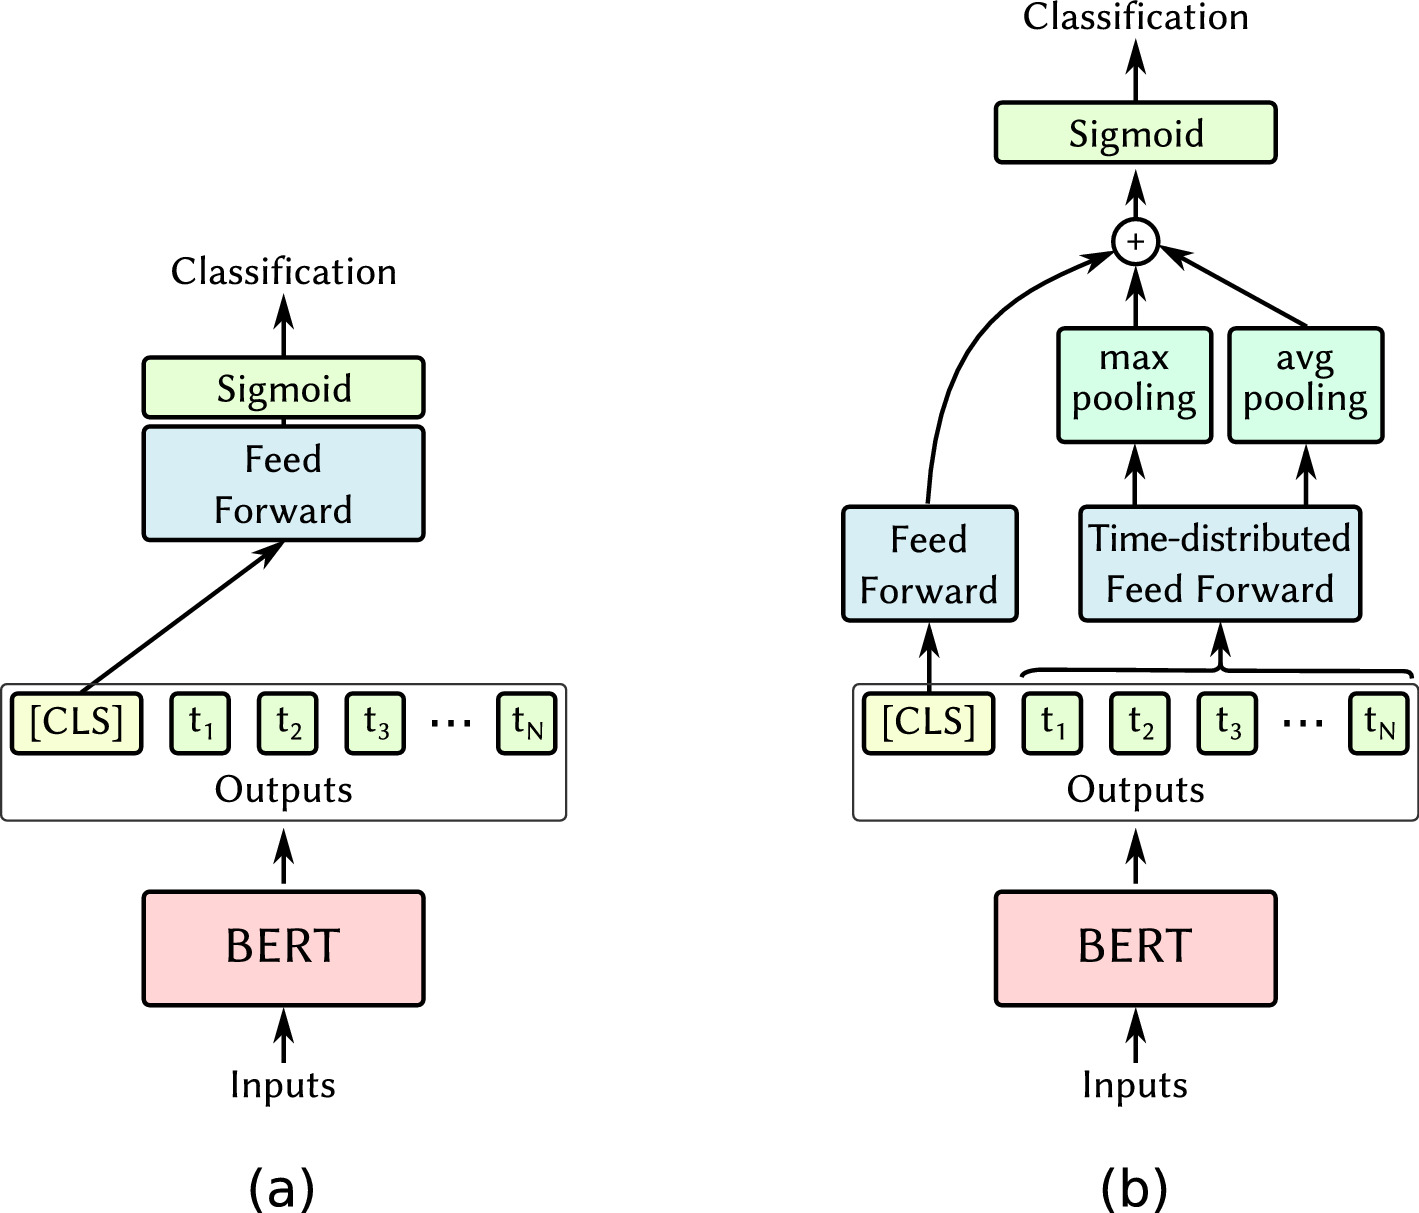

In [12]:
import torch
import torch.nn as nn
import transformers
from transformers import (
    AutoModel, AutoConfig,
    AutoTokenizer, logging
)
logging.set_verbosity_error()
logging.set_verbosity_warning()

train_text = train['excerpt'][:16].tolist()
max_seq_length = 256
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
model = AutoModel.from_pretrained(_pretrained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

clear_output()

features = tokenizer.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    padding='max_length',
    max_length=max_seq_length,
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

with torch.no_grad():
    outputs = model(features['input_ids'], features['attention_mask'])
last_hidden_state = outputs[0]

In [13]:
mean_pooling_embeddings = torch.mean(last_hidden_state, 1)
_, max_pooling_embeddings = torch.max(last_hidden_state, 1)
mean_max_embeddings = torch.cat((mean_pooling_embeddings, max_pooling_embeddings), 1)
logits = nn.Linear(config.hidden_size*2, 1)(mean_max_embeddings) # twice the hidden size

print(f'Last Hidden State Output Shape: {last_hidden_state.detach().numpy().shape}')
print(f'Mean-Max Embeddings Output Shape: {mean_max_embeddings.detach().numpy().shape}')
print(f'Logits Shape: {logits.detach().numpy().shape}')

del config, model, tokenizer, features
gc.collect();

Last Hidden State Output Shape: (16, 256, 768)
Mean-Max Embeddings Output Shape: (16, 1536)
Logits Shape: (16, 1)


Conv-1D Pooling

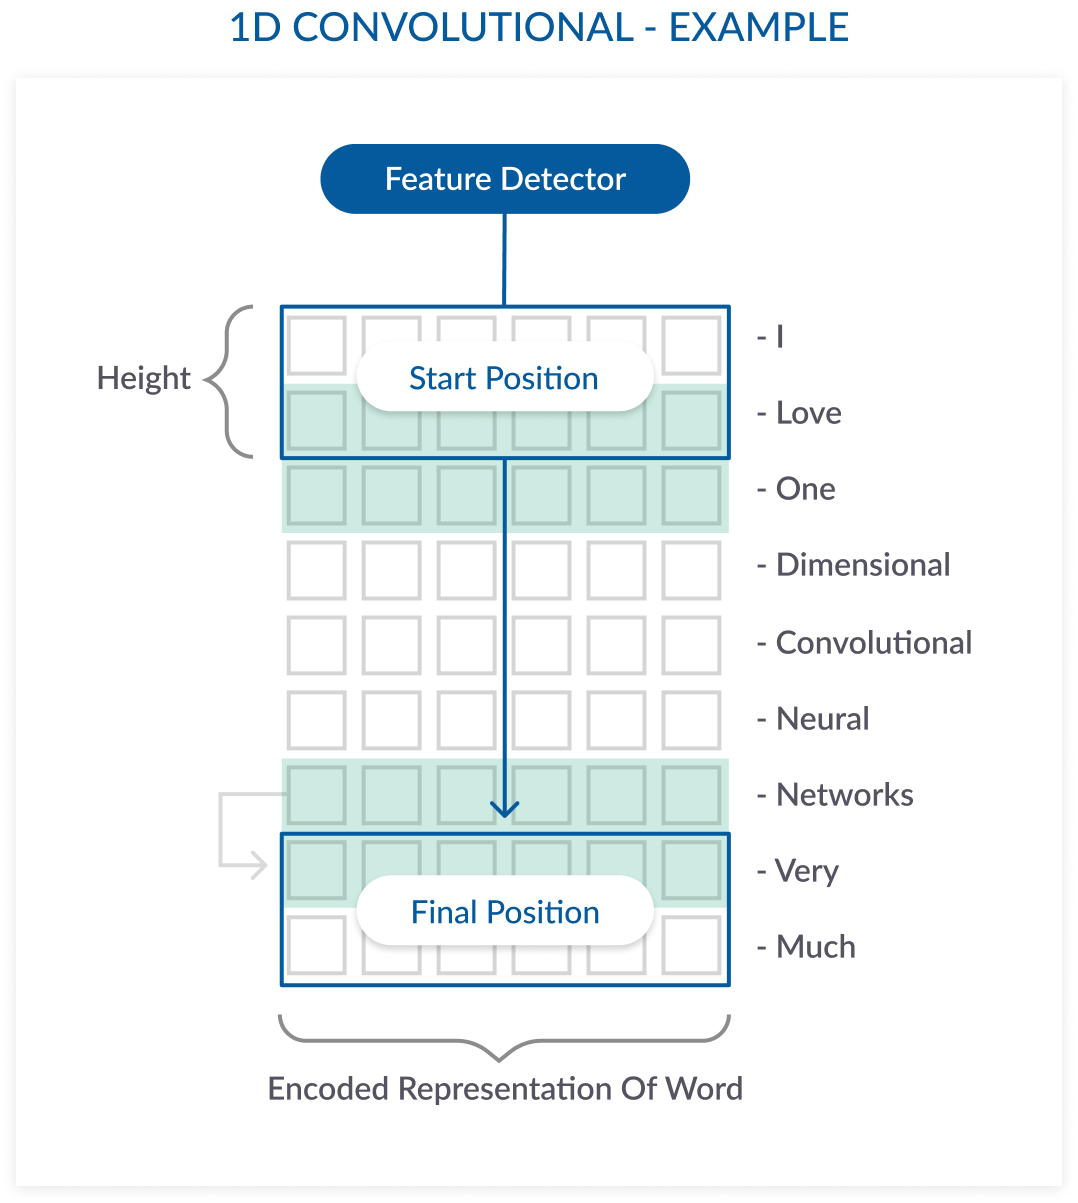

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import (
    AutoModel, AutoConfig,
    AutoTokenizer, logging
)
logging.set_verbosity_error()
logging.set_verbosity_warning()

train_text = train['excerpt'][:16].tolist()
max_seq_length = 256
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
model = AutoModel.from_pretrained(_pretrained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

clear_output()

features = tokenizer.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    padding='max_length',
    max_length=max_seq_length,
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

with torch.no_grad():
    outputs = model(features['input_ids'], features['attention_mask'])
last_hidden_state = outputs[0]

In [ ]:
# first define layers
cnn1 = nn.Conv1d(768, 256, kernel_size=2, padding=1)
cnn2 = nn.Conv1d(256, 1, kernel_size=2, padding=1)

last_hidden_state = last_hidden_state.permute(0, 2, 1)
cnn_embeddings = F.relu(cnn1(last_hidden_state))
cnn_embeddings = cnn2(cnn_embeddings)
logits, _ = torch.max(cnn_embeddings, 2)

print(f'Last Hidden State Output Shape: {last_hidden_state.detach().numpy().shape}')
print(f'CNN Embeddings Output Shape: {cnn_embeddings.detach().numpy().shape}')
print(f'Logits Shape: {logits.detach().numpy().shape}')

del config, model, tokenizer, features
gc.collect();

CLS Layer Embeddings

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import (
    AutoModel, AutoConfig,
    AutoTokenizer, logging
)
logging.set_verbosity_error()
logging.set_verbosity_warning()

train_text = train['excerpt'][:16].tolist()
max_seq_length = 256
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
config.update({'output_hidden_states':True})
model = AutoModel.from_pretrained(_pretrained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

clear_output()

features = tokenizer.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    padding='max_length',
    max_length=max_seq_length,
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

with torch.no_grad():
    outputs = model(features['input_ids'], features['attention_mask'])
all_hidden_states = torch.stack(outputs[2])

layer_index = 11 # second to last hidden layer
cls_embeddings = all_hidden_states[layer_index+1, :, 0] # layer_index+1 as we have 13 layers (embedding + num of blocks)

logits = nn.Linear(config.hidden_size, 1)(cls_embeddings) # regression head

print(f'Hidden States Output Shape: {all_hidden_states.detach().numpy().shape}')
print(f'CLS Embeddings Output Shape: {cls_embeddings.detach().numpy().shape}')
print(f'Logits Shape: {logits.detach().numpy().shape}')

del config, model, tokenizer, features
gc.collect();

Hidden States Output Shape: (13, 16, 256, 768)
CLS Embeddings Output Shape: (16, 768)
Logits Shape: (16, 1)


Concatenate Pooling

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import (
    AutoModel, AutoConfig,
    AutoTokenizer, logging
)
logging.set_verbosity_error()
logging.set_verbosity_warning()

train_text = train['excerpt'][:16].tolist()
max_seq_length = 256
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
config.update({'output_hidden_states':True})
model = AutoModel.from_pretrained(_pretrained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

clear_output()

features = tokenizer.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    padding='max_length',
    max_length=max_seq_length,
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

with torch.no_grad():
    outputs = model(features['input_ids'], features['attention_mask'])
all_hidden_states = torch.stack(outputs[2])

concatenate_pooling = torch.cat(
    (all_hidden_states[-1], all_hidden_states[-2], all_hidden_states[-3], all_hidden_states[-4]),-1
)
concatenate_pooling = concatenate_pooling[:, 0]

logits = nn.Linear(config.hidden_size*4, 1)(concatenate_pooling) # regression head

print(f'Hidden States Output Shape: {all_hidden_states.detach().numpy().shape}')
print(f'Concatenate Pooling Output Shape: {concatenate_pooling.detach().numpy().shape}')
print(f'Logits Shape: {logits.detach().numpy().shape}')

del config, model, tokenizer, features
gc.collect();

Hidden States Output Shape: (13, 16, 256, 768)
Concatenate Pooling Output Shape: (16, 3072)
Logits Shape: (16, 1)


Weighted Layer Pooling

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import (
    AutoModel, AutoConfig,
    AutoTokenizer, logging
)
logging.set_verbosity_error()
logging.set_verbosity_warning()

train_text = train['excerpt'][:16].tolist()
max_seq_length = 256
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
config.update({'output_hidden_states':True})
model = AutoModel.from_pretrained(_pretrained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

clear_output()

features = tokenizer.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    padding='max_length',
    max_length=max_seq_length,
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

with torch.no_grad():
    outputs = model(features['input_ids'], features['attention_mask'])
all_hidden_states = torch.stack(outputs[2])

In [18]:
class WeightedLayerPooling(nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 4, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None \
            else nn.Parameter(
                torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
            )

    def forward(self, all_hidden_states):
        all_layer_embedding = all_hidden_states[self.layer_start:, :, :, :]
        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()
        return weighted_average

layer_start = 9
pooler = WeightedLayerPooling(
    config.num_hidden_layers,
    layer_start=layer_start, layer_weights=None
)
weighted_pooling_embeddings = pooler(all_hidden_states)
weighted_pooling_embeddings = weighted_pooling_embeddings[:, 0]
logits = nn.Linear(config.hidden_size, 1)(weighted_pooling_embeddings)

print(f'Hidden States Output Shape: {all_hidden_states.detach().numpy().shape}')
print(f'Weighted Pooling Output Shape: {weighted_pooling_embeddings.detach().numpy().shape}')
print(f'Logits Shape: {logits.detach().numpy().shape}')

del config, model, tokenizer, features
gc.collect();

Hidden States Output Shape: (13, 16, 256, 768)
Weighted Pooling Output Shape: (16, 768)
Logits Shape: (16, 1)


LSTM/GRU Pooling

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import (
    AutoModel, AutoConfig,
    AutoTokenizer, logging
)
logging.set_verbosity_error()
logging.set_verbosity_warning()

train_text = train['excerpt'][:16].tolist()
max_seq_length = 256
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
config.update({'output_hidden_states':True})
model = AutoModel.from_pretrained(_pretrained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

clear_output()

features = tokenizer.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    padding='max_length',
    max_length=max_seq_length,
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

with torch.no_grad():
    outputs = model(features['input_ids'], features['attention_mask'])
all_hidden_states = torch.stack(outputs[2])

In [20]:
class LSTMPooling(nn.Module):
    def __init__(self, num_layers, hidden_size, hiddendim_lstm):
        super(LSTMPooling, self).__init__()
        self.num_hidden_layers = num_layers
        self.hidden_size = hidden_size
        self.hiddendim_lstm = hiddendim_lstm
        self.lstm = nn.LSTM(self.hidden_size, self.hiddendim_lstm, batch_first=True)
        self.dropout = nn.Dropout(0.1)

    def forward(self, all_hidden_states):
        ## forward
        hidden_states = torch.stack([all_hidden_states[layer_i][:, 0].squeeze()
                                     for layer_i in range(1, self.num_hidden_layers+1)], dim=-1)
        hidden_states = hidden_states.view(-1, self.num_hidden_layers, self.hidden_size)
        out, _ = self.lstm(hidden_states, None)
        out = self.dropout(out[:, -1, :])
        return out

hiddendim_lstm = 256
pooler = LSTMPooling(config.num_hidden_layers, config.hidden_size, hiddendim_lstm)
lstm_pooling_embeddings = pooler(all_hidden_states)
logits = nn.Linear(hiddendim_lstm, 1)(lstm_pooling_embeddings) # regression head

print(f'Hidden States Output Shape: {all_hidden_states.detach().numpy().shape}')
print(f'LSTM Pooling Output Shape: {lstm_pooling_embeddings.detach().numpy().shape}')
print(f'Logits Shape: {logits.detach().numpy().shape}')

del config, model, tokenizer, features
gc.collect();

Hidden States Output Shape: (13, 16, 256, 768)
LSTM Pooling Output Shape: (16, 256)
Logits Shape: (16, 1)


Attention Pooling

In [22]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import (
    AutoModel, AutoConfig,
    AutoTokenizer, logging
)
logging.set_verbosity_error()
logging.set_verbosity_warning()

train_text = train['excerpt'][:16].tolist()
max_seq_length = 256
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
config.update({'output_hidden_states':True})
model = AutoModel.from_pretrained(_pretrained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

clear_output()

features = tokenizer.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    padding='max_length',
    max_length=max_seq_length,
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

with torch.no_grad():
    outputs = model(features['input_ids'], features['attention_mask'])
all_hidden_states = torch.stack(outputs[2])

In [23]:
class AttentionPooling(nn.Module):
    def __init__(self, num_layers, hidden_size, hiddendim_fc):
        super(AttentionPooling, self).__init__()
        self.num_hidden_layers = num_layers
        self.hidden_size = hidden_size
        self.hiddendim_fc = hiddendim_fc
        self.dropout = nn.Dropout(0.1)

        q_t = np.random.normal(loc=0.0, scale=0.1, size=(1, self.hidden_size))
        self.q = nn.Parameter(torch.from_numpy(q_t)).float()
        w_ht = np.random.normal(loc=0.0, scale=0.1, size=(self.hidden_size, self.hiddendim_fc))
        self.w_h = nn.Parameter(torch.from_numpy(w_ht)).float()

    def forward(self, all_hidden_states):
        hidden_states = torch.stack([all_hidden_states[layer_i][:, 0].squeeze()
                                     for layer_i in range(1, self.num_hidden_layers+1)], dim=-1)
        hidden_states = hidden_states.view(-1, self.num_hidden_layers, self.hidden_size)
        out = self.attention(hidden_states)
        out = self.dropout(out)
        return out

    def attention(self, h):
        v = torch.matmul(self.q, h.transpose(-2, -1)).squeeze(1)
        v = F.softmax(v, -1)
        v_temp = torch.matmul(v.unsqueeze(1), h).transpose(-2, -1)
        v = torch.matmul(self.w_h.transpose(1, 0), v_temp).squeeze(2)
        return v

hiddendim_fc = 128
pooler = AttentionPooling(config.num_hidden_layers, config.hidden_size, hiddendim_fc)
attention_pooling_embeddings = pooler(all_hidden_states)
logits = nn.Linear(hiddendim_fc, 1)(attention_pooling_embeddings) # regression head

print(f'Hidden States Output Shape: {all_hidden_states.detach().numpy().shape}')
print(f'Attention Pooling Output Shape: {attention_pooling_embeddings.detach().numpy().shape}')
print(f'Logits Shape: {logits.detach().numpy().shape}')

del config, model, tokenizer, features
gc.collect();

Hidden States Output Shape: (13, 16, 256, 768)
Attention Pooling Output Shape: (16, 128)
Logits Shape: (16, 1)


WKPooling

In [24]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from transformers import (
    AutoModel, AutoConfig,
    AutoTokenizer, logging
)
logging.set_verbosity_error()
logging.set_verbosity_warning()

train_text = train['excerpt'][:16].tolist()
max_seq_length = 256
_pretrained_model = 'roberta-base'

config = AutoConfig.from_pretrained(_pretrained_model)
config.update({'output_hidden_states':True})
model = AutoModel.from_pretrained(_pretrained_model, config=config)
tokenizer = AutoTokenizer.from_pretrained(_pretrained_model)

clear_output()

features = tokenizer.batch_encode_plus(
    train_text,
    add_special_tokens=True,
    padding='max_length',
    max_length=max_seq_length,
    truncation=True,
    return_tensors='pt',
    return_attention_mask=True
)

with torch.no_grad():
    outputs = model(features['input_ids'], features['attention_mask'])
all_hidden_states = torch.stack(outputs[2])

In [25]:
class WKPooling(nn.Module):
    def __init__(self, layer_start: int = 4, context_window_size: int = 2):
        super(WKPooling, self).__init__()
        self.layer_start = layer_start
        self.context_window_size = context_window_size

    def forward(self, all_hidden_states):
        ft_all_layers = all_hidden_states
        org_device = ft_all_layers.device
        all_layer_embedding = ft_all_layers.transpose(1,0)
        all_layer_embedding = all_layer_embedding[:, self.layer_start:, :, :]  # Start from 4th layers output

        # torch.qr is slow on GPU (see https://github.com/pytorch/pytorch/issues/22573). So compute it on CPU until issue is fixed
        all_layer_embedding = all_layer_embedding.cpu()

        attention_mask = features['attention_mask'].cpu().numpy()
        unmask_num = np.array([sum(mask) for mask in attention_mask]) - 1  # Not considering the last item
        embedding = []

        # One sentence at a time
        for sent_index in range(len(unmask_num)):
            sentence_feature = all_layer_embedding[sent_index, :, :unmask_num[sent_index], :]
            one_sentence_embedding = []
            # Process each token
            for token_index in range(sentence_feature.shape[1]):
                token_feature = sentence_feature[:, token_index, :]
                # 'Unified Word Representation'
                token_embedding = self.unify_token(token_feature)
                one_sentence_embedding.append(token_embedding)

            ##features.update({'sentence_embedding': features['cls_token_embeddings']})

            one_sentence_embedding = torch.stack(one_sentence_embedding)
            sentence_embedding = self.unify_sentence(sentence_feature, one_sentence_embedding)
            embedding.append(sentence_embedding)

        output_vector = torch.stack(embedding).to(org_device)
        return output_vector

    def unify_token(self, token_feature):
        ## Unify Token Representation
        window_size = self.context_window_size

        alpha_alignment = torch.zeros(token_feature.size()[0], device=token_feature.device)
        alpha_novelty = torch.zeros(token_feature.size()[0], device=token_feature.device)

        for k in range(token_feature.size()[0]):
            left_window = token_feature[k - window_size:k, :]
            right_window = token_feature[k + 1:k + window_size + 1, :]
            window_matrix = torch.cat([left_window, right_window, token_feature[k, :][None, :]])
            Q, R = torch.qr(window_matrix.T)

            r = R[:, -1]
            alpha_alignment[k] = torch.mean(self.norm_vector(R[:-1, :-1], dim=0), dim=1).matmul(R[:-1, -1]) / torch.norm(r[:-1])
            alpha_alignment[k] = 1 / (alpha_alignment[k] * window_matrix.size()[0] * 2)
            alpha_novelty[k] = torch.abs(r[-1]) / torch.norm(r)

        # Sum Norm
        alpha_alignment = alpha_alignment / torch.sum(alpha_alignment)  # Normalization Choice
        alpha_novelty = alpha_novelty / torch.sum(alpha_novelty)

        alpha = alpha_novelty + alpha_alignment
        alpha = alpha / torch.sum(alpha)  # Normalize

        out_embedding = torch.mv(token_feature.t(), alpha)
        return out_embedding

    def norm_vector(self, vec, p=2, dim=0):
        ## Implements the normalize() function from sklearn
        vec_norm = torch.norm(vec, p=p, dim=dim)
        return vec.div(vec_norm.expand_as(vec))

    def unify_sentence(self, sentence_feature, one_sentence_embedding):
        ## Unify Sentence By Token Importance
        sent_len = one_sentence_embedding.size()[0]

        var_token = torch.zeros(sent_len, device=one_sentence_embedding.device)
        for token_index in range(sent_len):
            token_feature = sentence_feature[:, token_index, :]
            sim_map = self.cosine_similarity_torch(token_feature)
            var_token[token_index] = torch.var(sim_map.diagonal(-1))

        var_token = var_token / torch.sum(var_token)
        sentence_embedding = torch.mv(one_sentence_embedding.t(), var_token)

        return sentence_embedding

    def cosine_similarity_torch(self, x1, x2=None, eps=1e-8):
        x2 = x1 if x2 is None else x2
        w1 = x1.norm(p=2, dim=1, keepdim=True)
        w2 = w1 if x2 is x1 else x2.norm(p=2, dim=1, keepdim=True)
        return torch.mm(x1, x2.t()) / (w1 * w2.t()).clamp(min=eps)

In [26]:
pooler = WKPooling(layer_start=9)
wkpooling_embeddings = pooler(all_hidden_states)
logits = nn.Linear(config.hidden_size, 1)(wkpooling_embeddings) # regression head

print(f'Hidden States Output Shape: {all_hidden_states.detach().numpy().shape}')
print(f'WKPooling Output Shape: {wkpooling_embeddings.detach().numpy().shape}')
print(f'Logits Shape: {logits.detach().numpy().shape}')

del config, model, tokenizer, features
gc.collect();

<ipython-input-25-359f1ded9b6b>:51: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2416.)
  Q, R = torch.qr(window_matrix.T)


Hidden States Output Shape: (13, 16, 256, 768)
WKPooling Output Shape: (16, 768)
Logits Shape: (16, 1)
